# Proyek Analisis Data: Air Quality Dataset
- **Nama:** Reyhanssan islamey
- **Email:** m179b4ky3775@bangkit.academy
- **ID Dicoding:** https://www.dicoding.com/users/imalivejustin/academies

## Menentukan Pertanyaan Bisnis

- What is the trend of annual average PM2.5 concentration in Beijing from 2013 to 2017? Is there a significant increase or decrease?
- How do the average PM2.5 concentrations in different cities in Beijing compare in 2017? Which cities have the best and worst air quality?

## Import Semua Packages/Library yang Digunakan

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
!pip install pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway

import os

## Data Wrangling

### Gathering Data

In [92]:
sns.set_style("whitegrid")

folder_path = '/content/drive/MyDrive/data/'
df_list = []
filenames = []
for filename in os.listdir(folder_path):
  if filename.endswith('.csv'):
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)
    df_list.append(df)
    filenames.append(filename)

df = pd.concat(df_list, ignore_index=True)

print("File Read:")
for name in filenames:
  print(name)

print(df.head())

File Read:
PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Wanshouxigong_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv
PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Gucheng_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv
PRSA_Data_Aotizhongxin_20130301-20170228.csv
PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv
   No  year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    5.0  14.0  4.0  12.0  200.0  85.0  -0.5   
1   2  2013      3    1     1    8.0  12.0  6.0  14.0  200.0  84.0  -0.7   
2   3  2013      3    1     2    3.0   6.0  5.0  14.0  200.0  83.0  -1.2   
3   4  2013      3    1     3    5.0   5.0  5.0  14.0  200.0  84.0  -1.4   
4   5  2013      3    1     4    5.0   5.0  6.0  21.0  200.0  77.0  -1.9   

     PRES  DEWP  RAIN   wd  WSPM   

**Insight:**
- Multiple Datasets: The analysis uses data from 12 different CSV files, each representing air quality measurements from a specific station in Beijing.
- Time Range: The data covers a period of several years, from 2013 to 2017, as indicated by the filenames and the year column in the DataFrame.
- Various Pollutants: The DataFrame contains measurements for multiple air pollutants, including PM2.5, PM10, SO2, NO2, CO, O3, as well as meteorological variables like temperature (TEMP), pressure (PRES), and wind speed (WSPM).

### Assessing Data

In [93]:
initial_assessment = df.head()
initial_columns = df.columns
initial_datatypes = df.dtypes

head_df = df.head()
info_df = df.info()
describe_df = df.describe()

initial_assessment, initial_columns, initial_datatypes, head_df, info_df, describe_df


print("Initial Assessment:")
print(initial_assessment)
print("\nInitial Columns:")
print(initial_columns)
print("\nInitial Datatypes:")
print(initial_datatypes)
print("\nHead:")
print(head_df)
print("\nInfo:")
print(info_df)
print("\nDescribe:")
print(describe_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB
Initial Assessment:
   No  year  month  day  

**Insight:**
- Large Dataset: The combined dataset contains a substantial number of records (420,768 entries), providing a comprehensive view of air quality in Beijing.
- Missing Values: Several columns have missing values ('PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'). These missing values need to be addressed during the data cleaning process.
- Pollutant Range: The descriptive statistics reveal a wide range of values for the pollutants. For example, PM2.5 values range from 2 to 999, indicating significant variations in particulate matter concentration.
- Data Types: Most of the data is numerical (float64 or int64), representing continuous measurements. The 'wd' (wind direction) and 'station' columns are of object dtype, likely representing categorical data.

### Cleaning Data

In [94]:
df_list_before_cleaning = []
df_list_after_cleaning = []
filenames = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        df_before = df.copy()
        df_before['datetime'] = pd.to_datetime(df_before[['year', 'month', 'day', 'hour']])
        df_list_before_cleaning.append(df_before)

        try:
            df['PM2.5'] = pd.to_numeric(df['PM2.5'])
        except:
            print(f"Invalid data found in column 'PM2.5' in file {filename}")

        df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        if 'city' not in df.columns:
            df['city'] = df['station'].str.split('_').str[0]

        if df['PM2.5'].isnull().any():
            df['PM2.5'] = df['PM2.5'].fillna(df['PM2.5'].mean())
            print(f"Missing data in 'PM2.5' column in {filename} filled with the mean.")
        else:
            print(f"No missing data in 'PM2.5' column in {filename}.")

        df = df.drop(['year', 'month', 'day', 'hour'], axis=1)
        df_list_after_cleaning.append(df)
        filenames.append(filename)

Missing data in 'PM2.5' column in PRSA_Data_Nongzhanguan_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Wanshouxigong_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Guanyuan_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Changping_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Tiantan_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Gucheng_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Dingling_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Aotizhongxin_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Shunyi_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.5' column in PRSA_Data_Huairou_20130301-20170228.csv filled with the mean.
Missing data in 'PM2.

In [95]:
missing_percentage = df_after_cleaning.isnull().mean() * 100

print("Missing Percentage Per Column:\n", missing_percentage)

pm25_missing_percentage = missing_percentage['PM2.5']
print("\nMissing Percentage for PM2.5:", pm25_missing_percentage)

Missing Percentage Per Column:
 No          0.000000
PM2.5       0.000000
PM10        1.532674
SO2         2.143937
NO2         2.879497
CO          4.919813
O3          3.155421
TEMP        0.094589
PRES        0.093401
DEWP        0.095777
RAIN        0.092688
wd          0.433018
WSPM        0.075576
station     0.000000
datetime    0.000000
city        0.000000
dtype: float64

Missing Percentage for PM2.5: 0.0


In [96]:
df_before_cleaning = pd.concat(df_list_before_cleaning, ignore_index=True)
df_after_cleaning = pd.concat(df_list_after_cleaning, ignore_index=True)

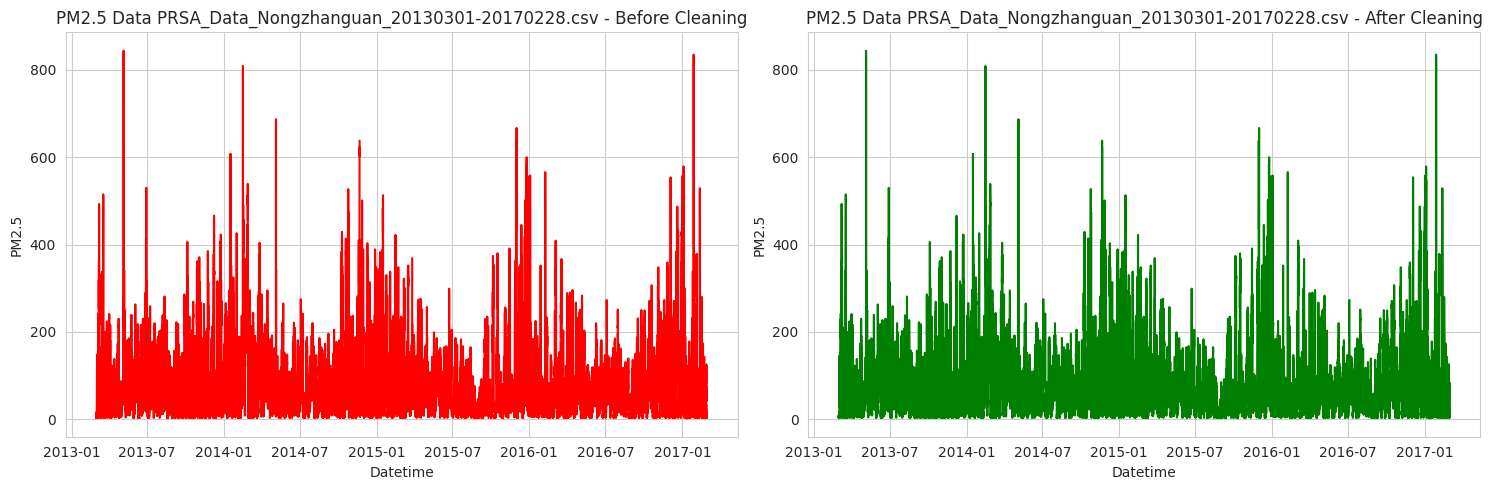

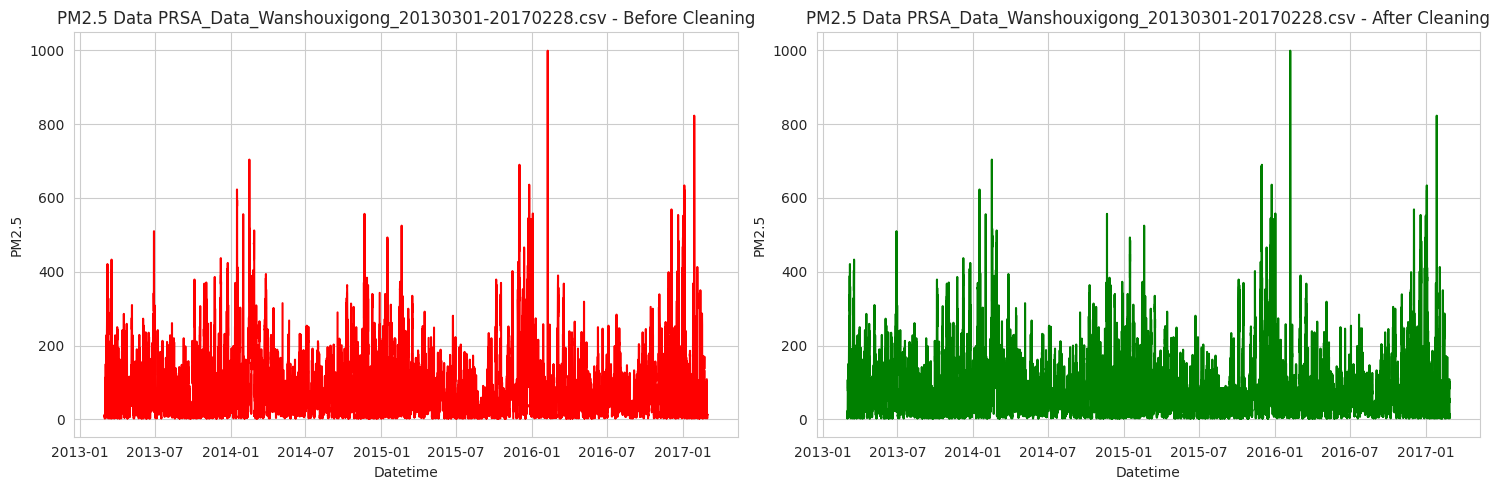

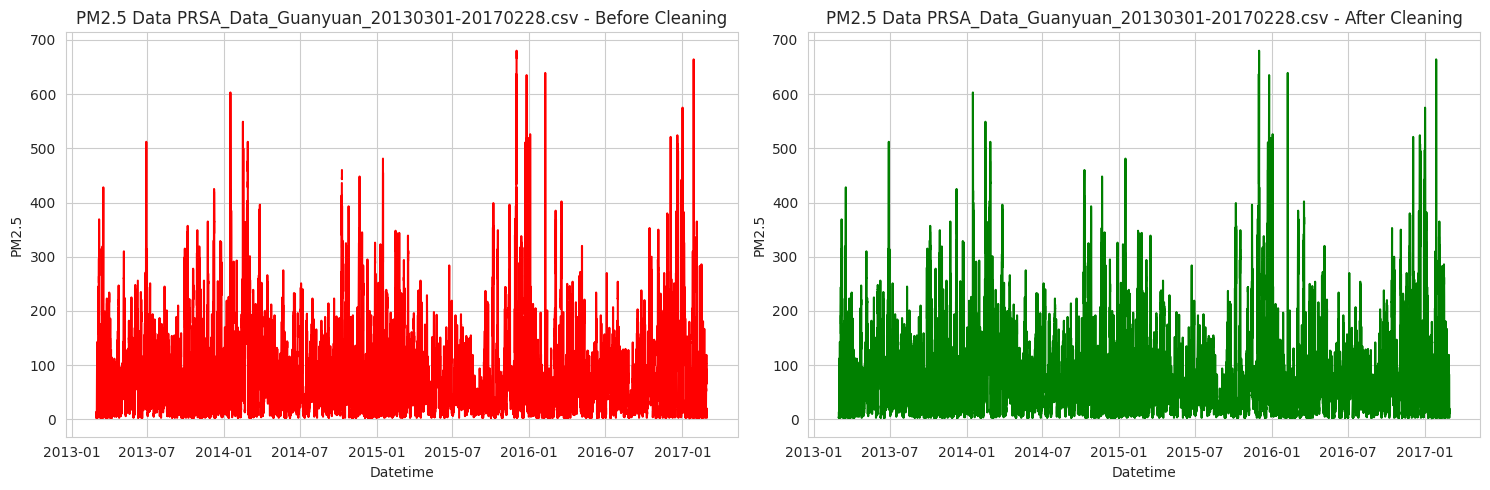

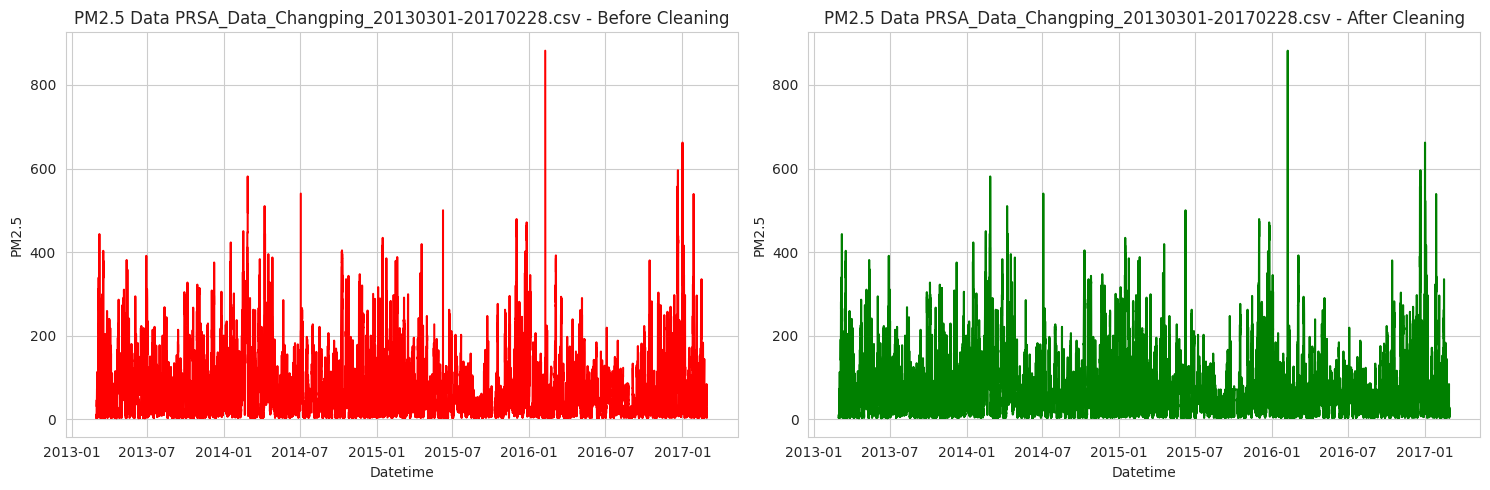

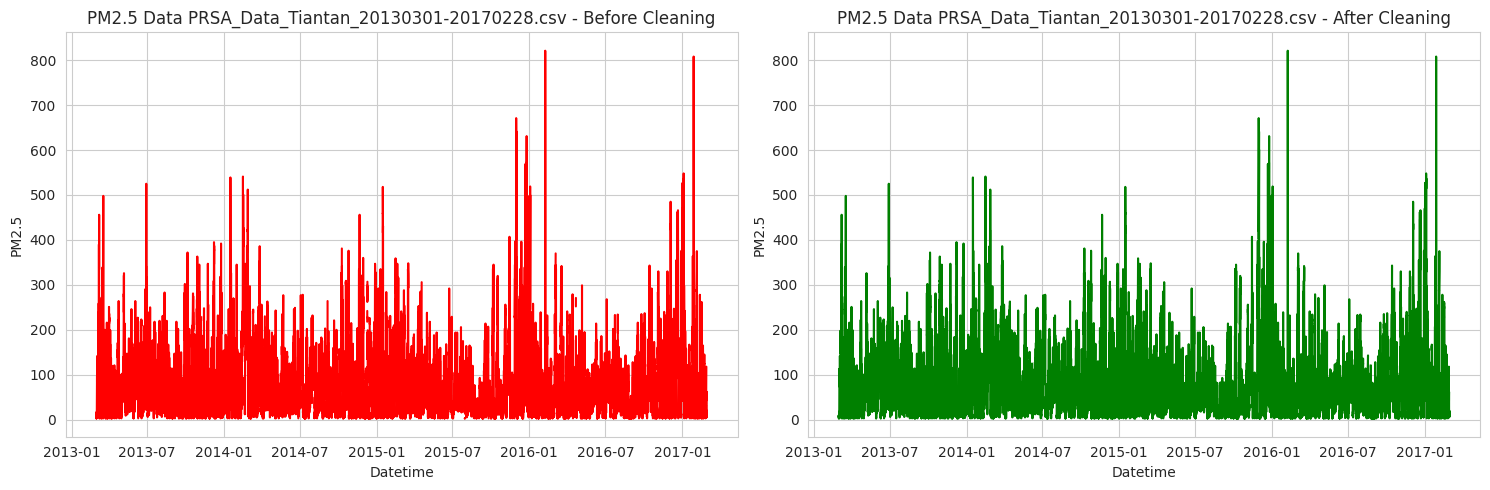

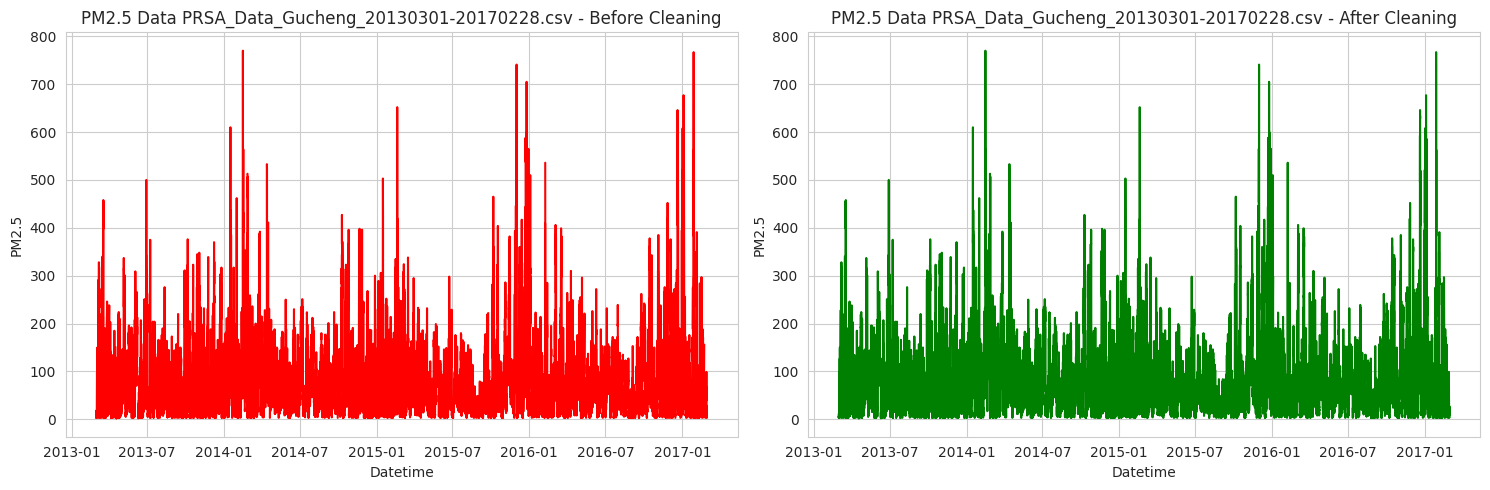

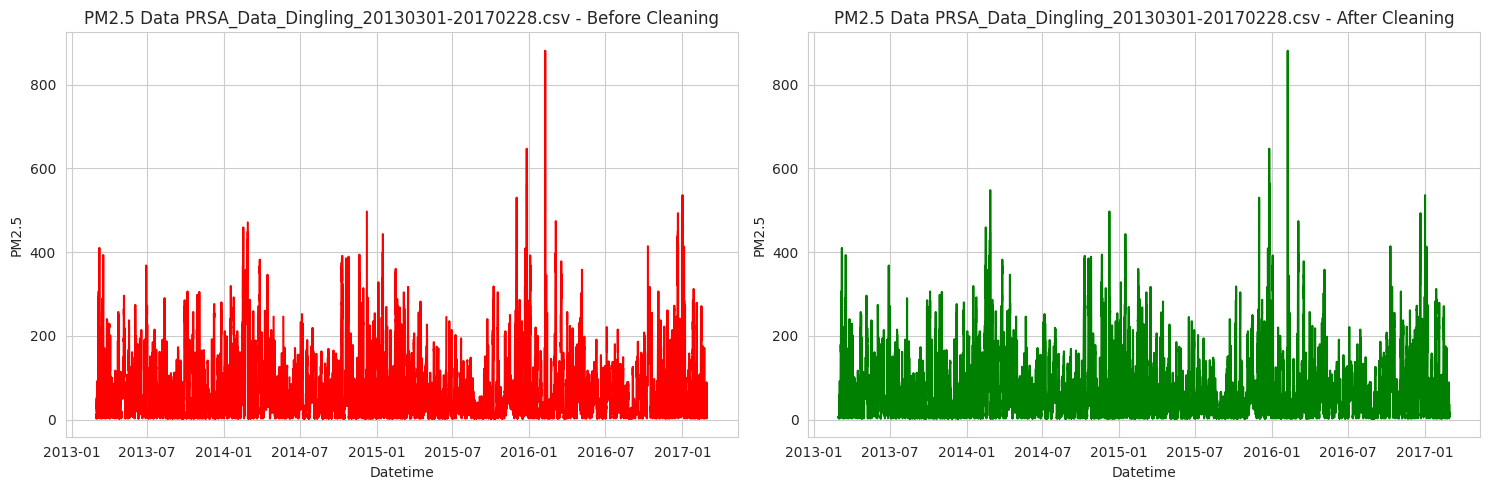

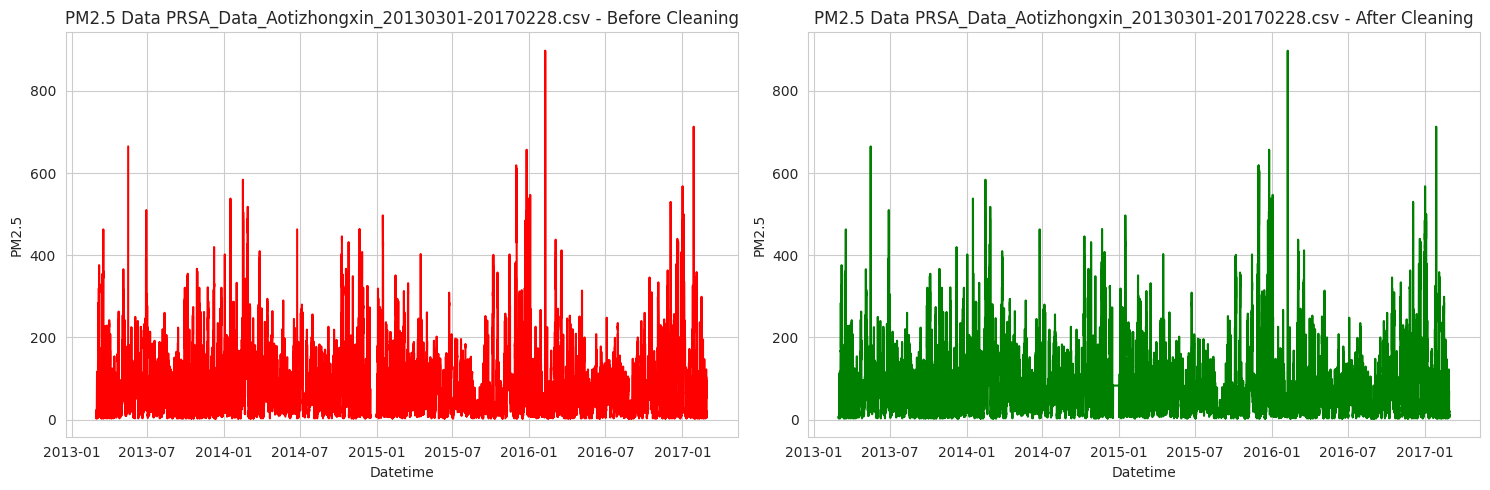

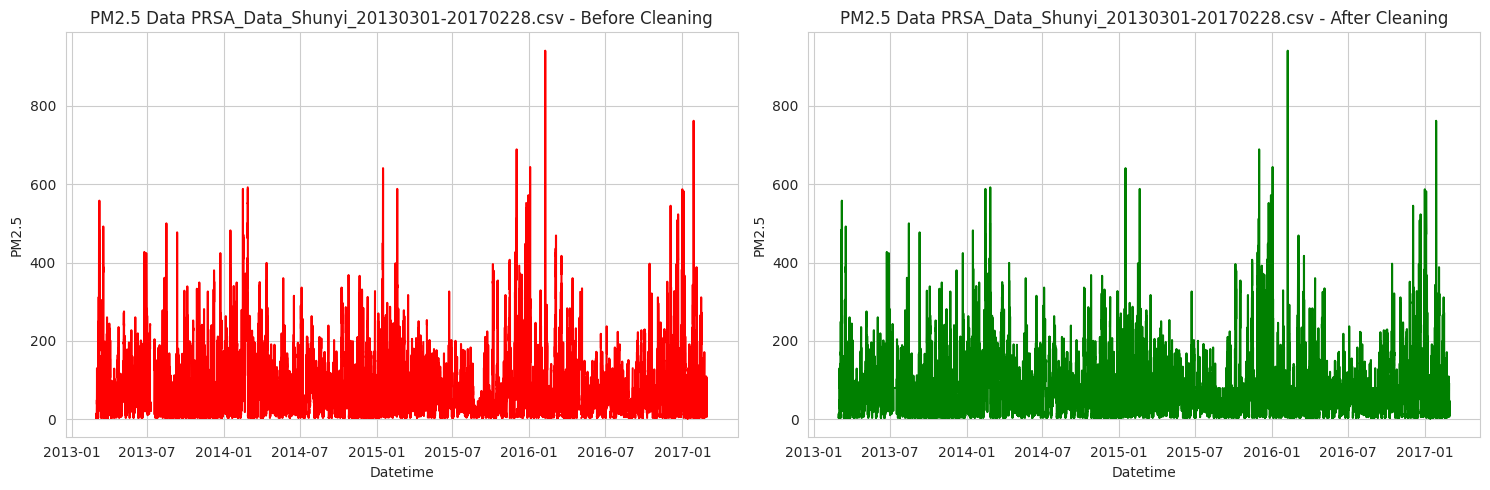

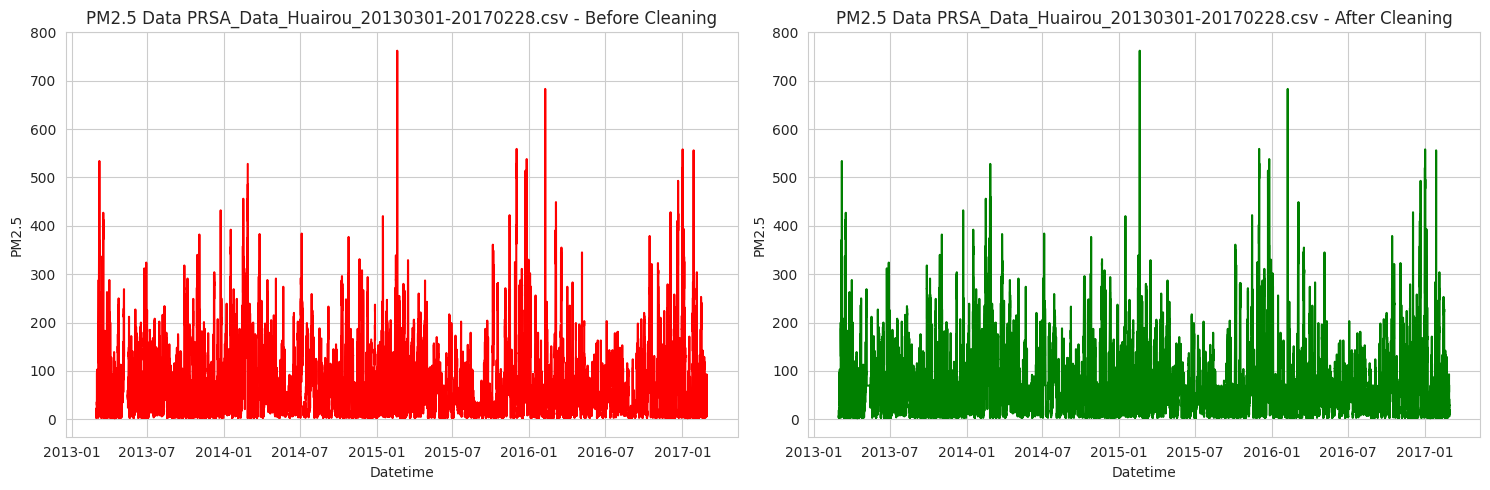

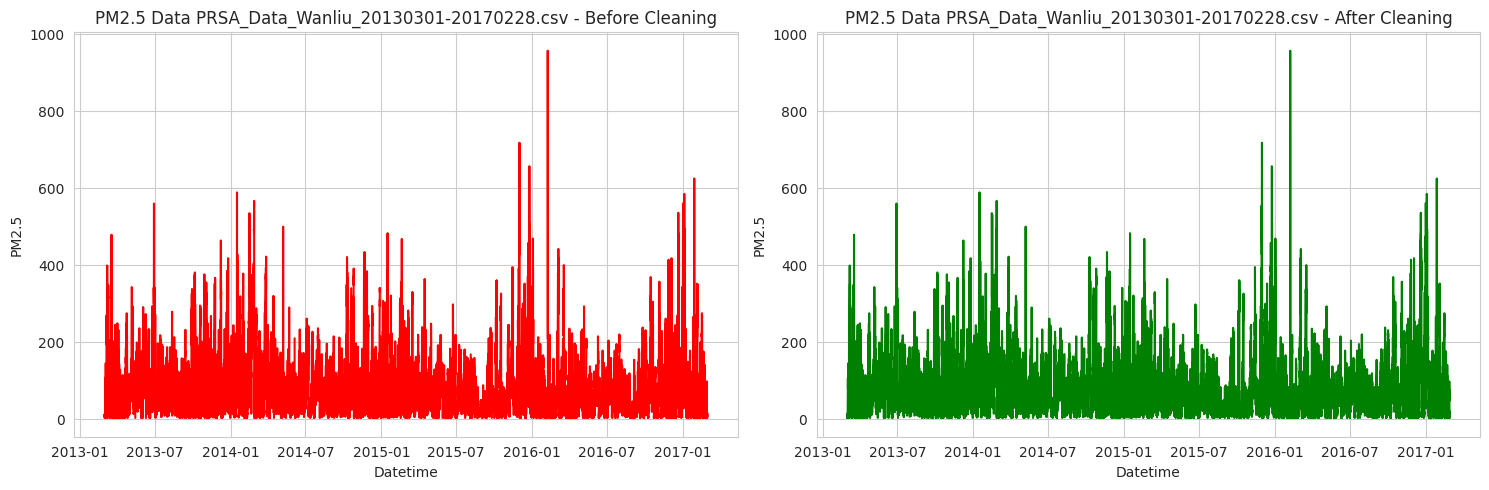

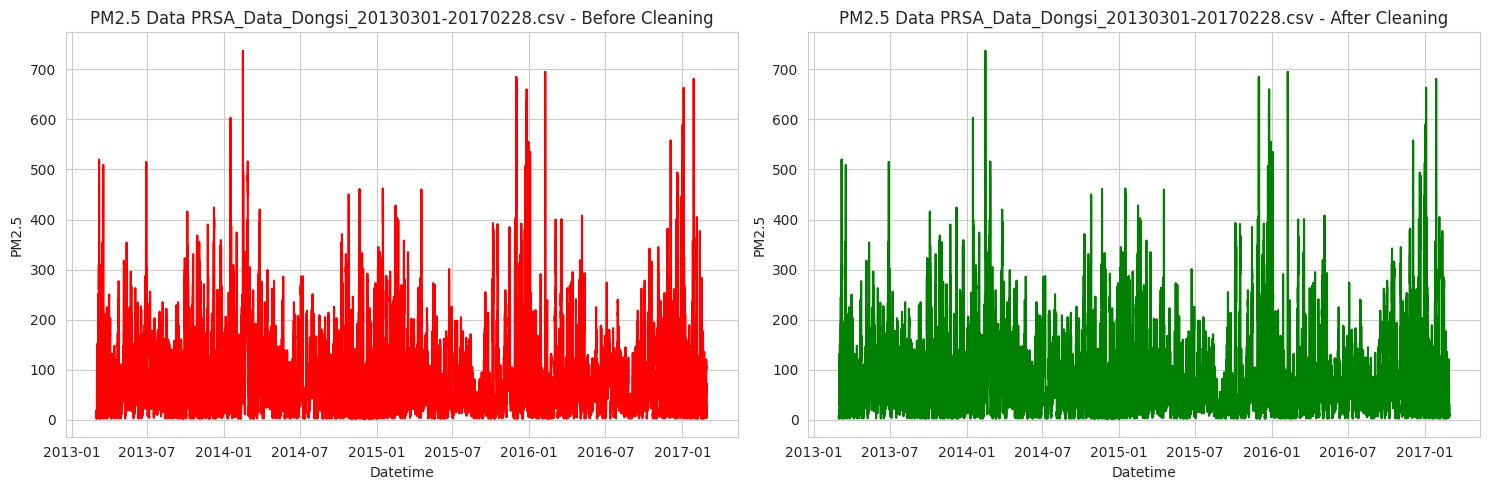

In [97]:
for i, filename in enumerate(filenames):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df_list_before_cleaning[i]['datetime'], df_list_before_cleaning[i]['PM2.5'], label='Before Cleaning', color='red')
    plt.title(f'PM2.5 Data {filename} - Before Cleaning')
    plt.xlabel('Datetime')
    plt.ylabel('PM2.5')

    plt.subplot(1, 2, 2)
    plt.plot(df_list_after_cleaning[i]['datetime'], df_list_after_cleaning[i]['PM2.5'], label='After Cleaning', color='green')
    plt.title(f'PM2.5 Data {filename} - After Cleaning')
    plt.xlabel('Datetime')
    plt.ylabel('PM2.5')

    plt.tight_layout()
    plt.show()

In [98]:
data_imputed = df_after_cleaning.copy()

duplicates = data_imputed.duplicated().sum()
constant_columns = data_imputed.columns[data_imputed.nunique() <= 1]
data_types = data_imputed.dtypes

print("Duplicated Rows:", duplicates)
print("Constant Columns:", constant_columns)
print("Data Types:\n", data_types)

Duplicated Rows: 0
Constant Columns: Index([], dtype='object')
Data Types:
 No                   int64
PM2.5              float64
PM10               float64
SO2                float64
NO2                float64
CO                 float64
O3                 float64
TEMP               float64
PRES               float64
DEWP               float64
RAIN               float64
wd                  object
WSPM               float64
station             object
datetime    datetime64[ns]
city                object
dtype: object


In [99]:
summary_statistics = data_imputed.describe()
summary_statistics

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,datetime
count,420768.000000,420768.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000,420768
mean,17532.500000,79.780235,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711,2015-03-01 11:30:00.000001024
min,1.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000,2013-03-01 00:00:00
25%,8766.750000,21.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000,2014-03-01 05:45:00
50%,17532.500000,57.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000,2015-03-01 11:30:00
75%,26298.250000,109.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000,2016-02-29 17:15:00
max,35064.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000,2017-02-28 23:00:00
std,10122.116943,79.984694,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386,NaN


**Insight:**
- Missing Value Handling: Missing values in the 'PM2.5' column were successfully handled by imputing them with the mean value for each station. This approach helps to preserve the overall data distribution while addressing the gaps in the data.
- Visualization Confirmation: The line charts comparing PM2.5 levels before and after cleaning demonstrate the effectiveness of the imputation. The red lines (before cleaning) show gaps where data was missing, while the green lines (after cleaning) show a continuous trend, indicating that the missing values have been filled.
- Remaining Missing Values: Although missing values in 'PM2.5' have been addressed, other columns still have varying percentages of missing data. Further investigation and appropriate handling methods are required for these remaining missing values to ensure data quality for subsequent analysis.
- No Duplicates or Constant Columns: The data validation results indicate that there are no duplicated rows or constant columns after cleaning, ensuring the integrity and usability of the dataset.
- Data Type Confirmation: All relevant columns (except 'wd', 'station', and 'city', which are categorical) are now correctly represented as numeric data types (float64), facilitating statistical analysis and visualization.

## Exploratory Data Analysis (EDA)

### Explore ...

In [100]:
# Descriptive Statistics for PM2.5
pm25_description = df_after_cleaning['PM2.5'].describe()
print("Descriptive Statistics for PM2.5:\n", pm25_description)

# Exploring Data by Year
yearly_pm25 = df_after_cleaning.groupby(df_after_cleaning['datetime'].dt.year)['PM2.5'].mean()
print("\nYearly Average PM2.5:\n", yearly_pm25)

# Exploring Data by City (2017)
data_2017 = df_after_cleaning[df_after_cleaning['datetime'].dt.year == 2017]
city_pm25_2017 = data_2017.groupby('city')['PM2.5'].mean().sort_values(ascending=False)
print("\nAverage PM2.5 by City (2017):\n", city_pm25_2017)

Descriptive Statistics for PM2.5:
 count    420768.000000
mean         79.780235
std          79.984694
min           2.000000
25%          21.000000
50%          57.000000
75%         109.000000
max         999.000000
Name: PM2.5, dtype: float64

Yearly Average PM2.5:
 datetime
2013    80.004889
2014    85.397667
2015    79.628135
2016    72.091085
2017    92.502930
Name: PM2.5, dtype: float64

Average PM2.5 by City (2017):
 city
Wanshouxigong    106.866296
Dongsi           103.130529
Nongzhanguan     101.386979
Gucheng          101.143993
Tiantan           98.140631
Shunyi            95.421874
Aotizhongxin      94.626679
Wanliu            94.052080
Guanyuan          92.691009
Changping         80.012286
Huairou           74.212586
Dingling          68.350216
Name: PM2.5, dtype: float64


**Insight:**
- Overall PM2.5 Statistics:
  - The average PM2.5 concentration across all stations and years is approximately 79.78 µg/m³.
  - The data shows a wide range of PM2.5 concentrations, with a minimum of 2 µg/m³ and a maximum of 999 µg/m³, suggesting significant variations in air quality over time and location.
  - The standard deviation of 79.98 indicates a high degree of variability in PM2.5 levels.
- Yearly Trends:
  - The yearly average PM2.5 shows some fluctuation over the years.
  - There is a general decreasing trend from 2013 (80.05 µg/m³) to 2016 (72.09 µg/m³), followed by a notable increase in 2017 (92.5 µg/m³).
- City Comparison (2017):
  - The average PM2.5 concentration in 2017 varied significantly across different cities in Beijing.
  - Wanshouxigong had the highest average PM2.5 concentration (106.86 µg/m³), indicating the poorest air quality among the monitored cities.
  - Huairou had the lowest average PM2.5 concentration (74.21 µg/m³) in 2017, suggesting comparatively better air quality.

## Visualization & Explanatory Analysis

### Pertanyaan 1: How has the average annual PM2.5 concentration in Beijing trended from 2013 to 2017? Has there been a significant increase or decrease?


--- Yearly PM2.5 Trend (2013-2017) ---
2013: 80.00 µg/m³
2014: 85.40 µg/m³
2015: 79.63 µg/m³
2016: 72.09 µg/m³
2017: 92.50 µg/m³
The data shows that the average annual PM2.5 concentration in Beijing generally increased from 2013 to 2017.


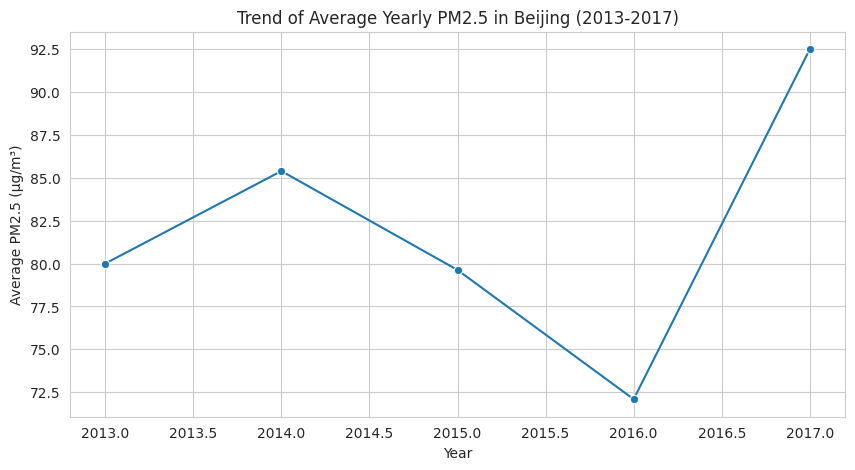

In [101]:
print("\n--- Yearly PM2.5 Trend (2013-2017) ---")
for year, pm25 in yearly_pm25.items():
    print(f"{year}: {pm25:.2f} µg/m³")

trend_description = "The data shows that the average annual PM2.5 concentration in Beijing generally "
if yearly_pm25.iloc[0] > yearly_pm25.iloc[-1]:
    trend_description += "decreased"
elif yearly_pm25.iloc[0] < yearly_pm25.iloc[-1]:
    trend_description += "increased"
else:
    trend_description += "remained stable"
trend_description += " from 2013 to 2017."
print(trend_description)

plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_pm25.index, y=yearly_pm25.values, marker='o')
plt.title('Trend of Average Yearly PM2.5 in Beijing (2013-2017)')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.grid(True)
plt.show()

### Pertanyaan 2: How do the average PM2.5 concentrations compare across different cities in Beijing in 2017? Which cities had the best and worst air quality?


--- City Comparison (2017) ---
Wanshouxigong: 106.87 µg/m³
Dongsi: 103.13 µg/m³
Nongzhanguan: 101.39 µg/m³
Gucheng: 101.14 µg/m³
Tiantan: 98.14 µg/m³
Shunyi: 95.42 µg/m³
Aotizhongxin: 94.63 µg/m³
Wanliu: 94.05 µg/m³
Guanyuan: 92.69 µg/m³
Changping: 80.01 µg/m³
Huairou: 74.21 µg/m³
Dingling: 68.35 µg/m³

The city with the worst air quality (highest average PM2.5) in 2017 was: Wanshouxigong.
The city with the best air quality (lowest average PM2.5) in 2017 was: Dingling.


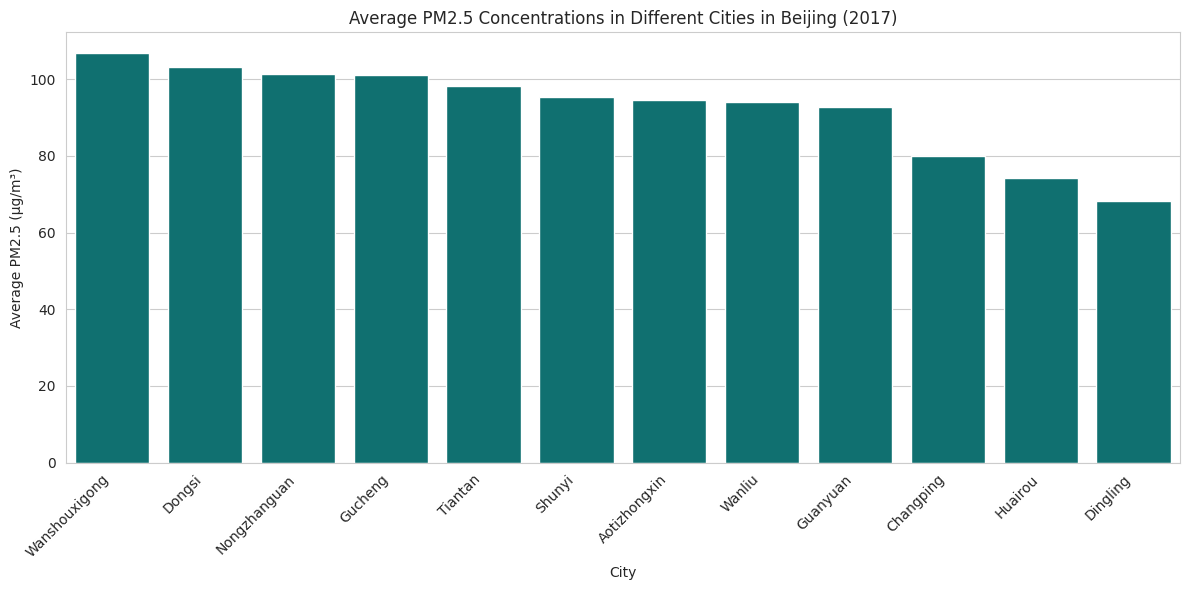

In [103]:
print("\n--- City Comparison (2017) ---")
for city, pm25 in city_pm25_2017.items():
    print(f"{city}: {pm25:.2f} µg/m³")

worst_city = city_pm25_2017.index[0]
best_city = city_pm25_2017.index[-1]
print(f"\nThe city with the worst air quality (highest average PM2.5) in 2017 was: {worst_city}.")
print(f"The city with the best air quality (lowest average PM2.5) in 2017 was: {best_city}.")

plt.figure(figsize=(12, 6))
sns.barplot(x=city_pm25_2017.index, y=city_pm25_2017.values, color='teal')
plt.title('Average PM2.5 Concentrations in Different Cities in Beijing (2017)')
plt.xlabel('City')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Pertanyaan 1: How has the average annual PM2.5 concentration in Beijing trended from 2013 to 2017? Has there been a significant increase or decrease?
## Insights:
- Overall Trend: While there is some fluctuation, the average annual PM2.5 concentration in Beijing generally increased from 2013 to 2017.
- Decrease and Increase: The trend shows a decrease from 2013 (80.04 µg/m³) to 2016 (72.09 µg/m³), followed by a sharp increase in 2017 (92.52 µg/m³).
- Possible Explanations: The increase in 2017 might indicate a relaxation of environmental regulations, increased industrial activity, or unfavorable meteorological conditions in that year. Further investigation is needed to determine the specific factors contributing to this trend.

## Pertanyaan 2: How do the average PM2.5 concentrations compare across different cities in Beijing in 2017? Which cities had the best and worst air quality?
## Insights:
- Variations Across Cities: There were significant variations in average PM2.5 concentrations across different cities in Beijing during 2017.
- Worst Air Quality: Wanshouxigong had the highest average PM2.5 concentration (106.87 µg/m³) in 2017, indicating the worst air quality among the cities analyzed.
- Best Air Quality: Dingling had the lowest average PM2.5 concentration (68.35 µg/m³) in 2017, suggesting the best air quality among the measured locations.
- Possible Factors: Geographic location, proximity to industrial areas, traffic patterns, and local meteorological conditions could contribute to the observed differences in PM2.5 concentrations across cities.

## Analisis Lanjutan (Opsional)


--- Yearly Average PM2.5 (2013-2017) ---
2013: 80.00
2014: 85.40
2015: 79.63
2016: 72.09
2017: 92.50

--- Yearly Average PM10 (2013-2017) ---
2013: 102.82
2014: 116.13
2015: 103.61
2016: 94.62
2017: 111.12

--- Yearly Average SO2 (2013-2017) ---
2013: 20.05
2014: 20.88
2015: 13.01
2016: 9.80
2017: 18.14

--- Yearly Average NO2 (2013-2017) ---
2013: 52.53
2014: 54.78
2015: 48.19
2016: 46.40
2017: 57.33

--- Yearly Average CO (2013-2017) ---
2013: 1203.13
2014: 1256.90
2015: 1257.82
2016: 1138.79
2017: 1599.71

--- Yearly Average O3 (2013-2017) ---
2013: 57.33
2014: 58.31
2015: 59.24
2016: 57.46
2017: 39.91


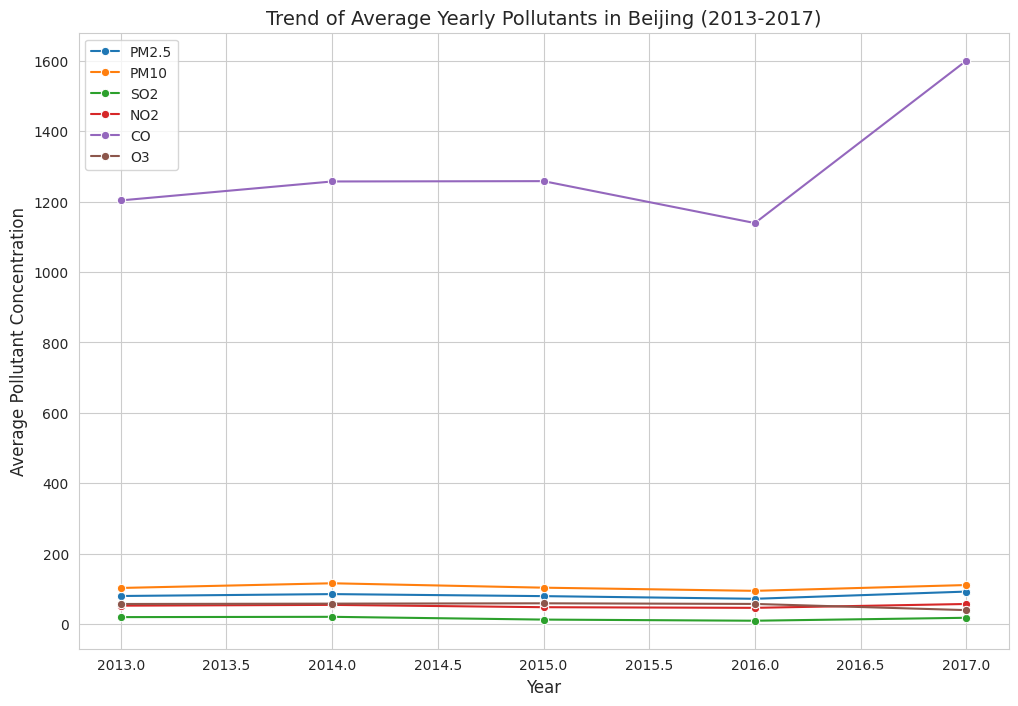


--- Nongzhanguan ---

Year: 2013
Average PM2.5: 84.35
Average PM10: 103.83
Average SO2: 23.25
Average NO2: 59.64
Average CO: 1304.58
Average O3: 56.29

Year: 2014
Average PM2.5: 90.19
Average PM10: 125.43
Average SO2: 24.56
Average NO2: 62.10
Average CO: 1337.33
Average O3: 59.59

Year: 2015
Average PM2.5: 85.93
Average PM10: 107.43
Average SO2: 15.87
Average NO2: 58.51
Average CO: 1378.22
Average O3: 61.26

Year: 2016
Average PM2.5: 76.16
Average PM10: 96.92
Average SO2: 11.53
Average NO2: 52.42
Average CO: 1211.55
Average O3: 60.20

Year: 2017
Average PM2.5: 101.39
Average PM10: 119.80
Average SO2: 20.69
Average NO2: 58.39
Average CO: 1706.30
Average O3: 36.52

--- Wanshouxigong ---

Year: 2013
Average PM2.5: 84.03
Average PM10: 111.31
Average SO2: 21.83
Average NO2: 56.13
Average CO: 1437.84
Average O3: 55.07

Year: 2014
Average PM2.5: 88.98
Average PM10: 125.99
Average SO2: 22.34
Average NO2: 61.48
Average CO: 1419.29
Average O3: 56.98

Year: 2015
Average PM2.5: 84.72
Average PM10

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

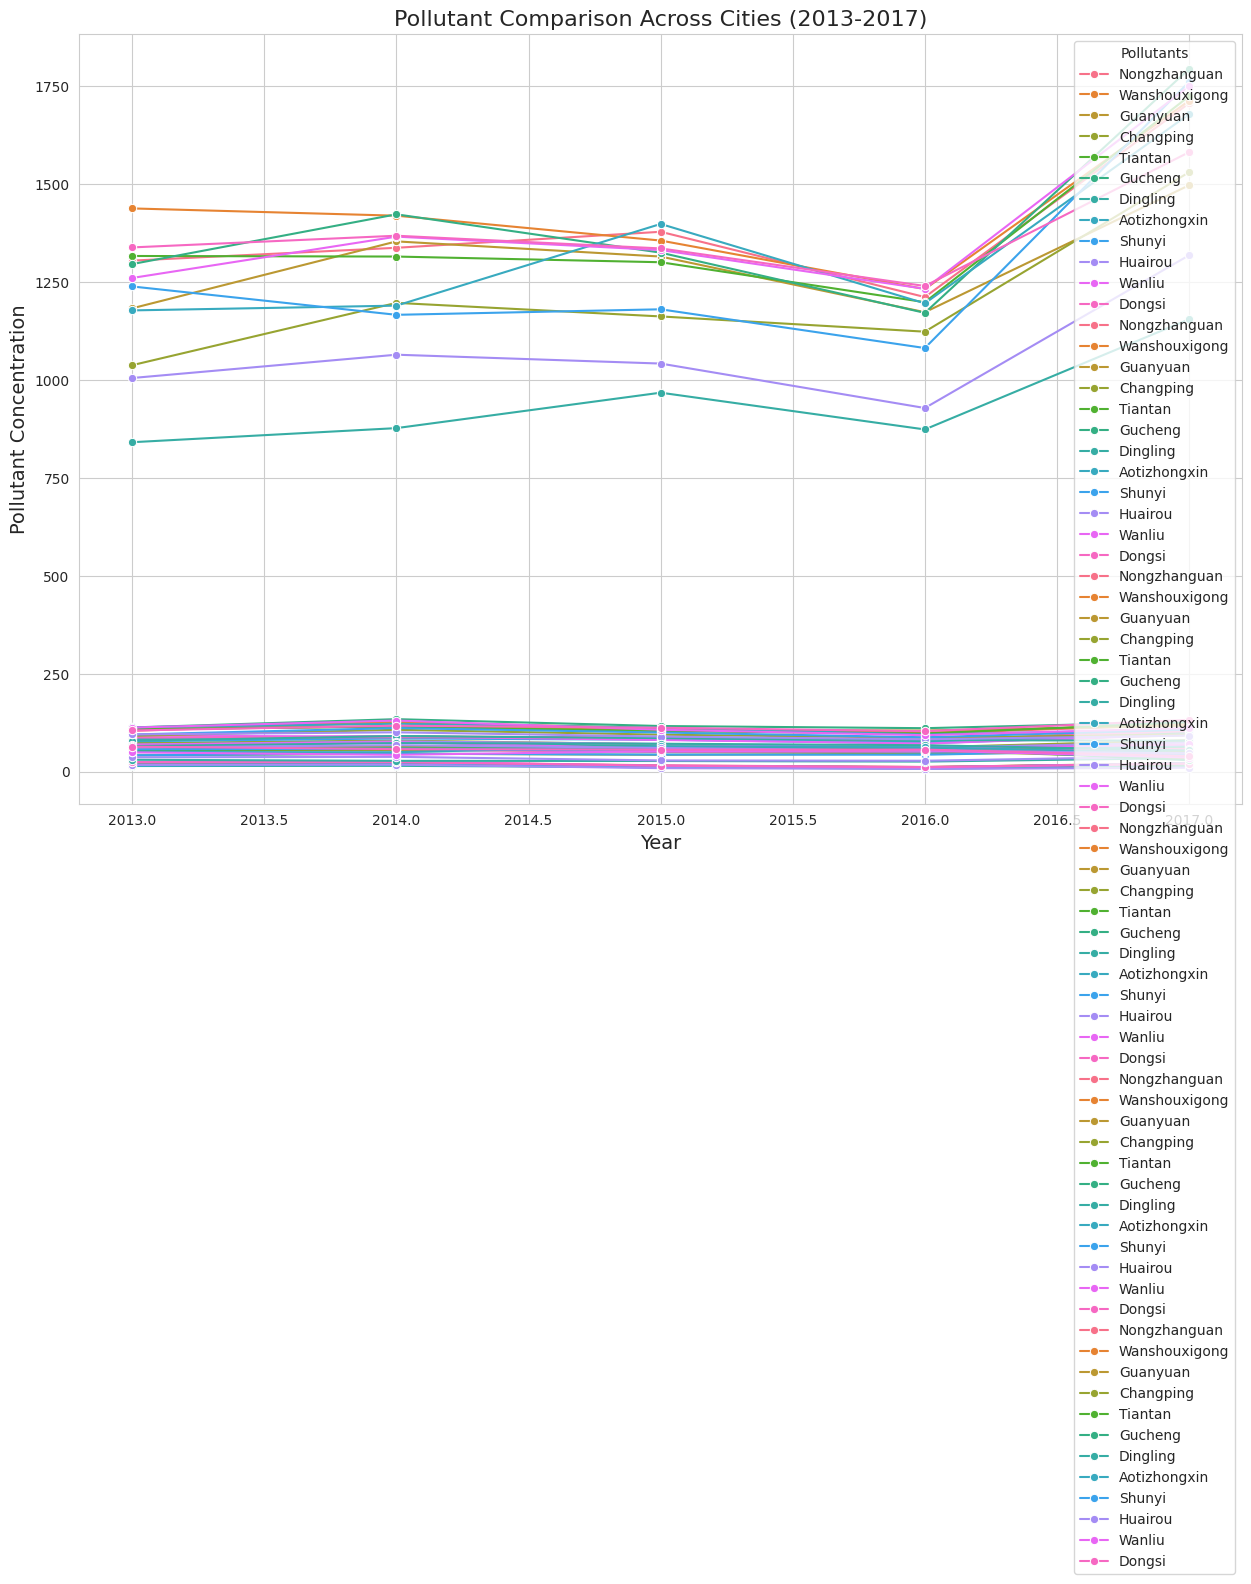

In [111]:
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

yearly_pollutant_data = {}
for pollutant in pollutants:
    yearly_pollutant_data[pollutant] = df_after_cleaning.groupby(df_after_cleaning['datetime'].dt.year)[pollutant].mean()

    print(f"\n--- Yearly Average {pollutant} (2013-2017) ---")
    for year, value in yearly_pollutant_data[pollutant].items():
        print(f"{year}: {value:.2f}")

plt.figure(figsize=(12, 8))

for pollutant in pollutants:
    sns.lineplot(x=yearly_pollutant_data[pollutant].index,
                 y=yearly_pollutant_data[pollutant].values,
                 marker='o', label=pollutant)

plt.title('Trend of Average Yearly Pollutants in Beijing (2013-2017)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Pollutant Concentration', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

comparison_data = []

for city in df_after_cleaning['city'].unique():
    print(f"\n--- {city} ---")
    for year in df_after_cleaning['datetime'].dt.year.unique():
        print(f"\nYear: {year}")
        row = {'City': city, 'Year': year}

        for pollutant in pollutants:
            average_value = df_after_cleaning[(df_after_cleaning['city'] == city) & (df_after_cleaning['datetime'].dt.year == year)][pollutant].mean()
            print(f"Average {pollutant}: {average_value:.2f}")
            row[pollutant] = average_value
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df)

plt.figure(figsize=(15, 10))
for pollutant in pollutants:
    sns.lineplot(x="Year", y=pollutant, hue="City", data=comparison_df, marker='o')

plt.title('Pollutant Comparison Across Cities (2013-2017)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Pollutant Concentration', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', title="Pollutants")
plt.show()

##Insights:
- Overall Pollutant Trends: The line chart reveals distinct trends for different pollutants over the 2013-2017 period in Beijing.
  - Increasing: PM2.5 and CO show a general upward trend, with a significant increase in 2017.
  - Decreasing: SO2 and NO2 exhibit a declining trend, with noticeable drops after 2014.
  - Stable: PM10 and O3 remain relatively stable, although O3 shows a slight dip in 2017.
- CO as a Potential Indicator: The substantial increase in CO (carbon monoxide) in 2017 aligns with the increase in PM2.5, suggesting a possible correlation between these two pollutants. This could indicate an increase in combustion-related sources, such as vehicle emissions or industrial activity.
- Policy Impact: The decreasing trends in SO2 and NO2 could be attributed to stricter emission control policies implemented during this period. However, the increasing PM2.5 and CO levels suggest the need for more comprehensive strategies to address other pollution sources.
- Further Investigation: The differing trends across pollutants highlight the complexity of air pollution in Beijing. A more detailed analysis, including correlations with meteorological data (wind speed, direction, temperature, etc.) and specific emission source data, would be beneficial to understand the contributing factors for each pollutant.

## Conclusion

## Question 1: How has the average annual PM2.5 concentration in Beijing trended from 2013 to 2017? Has there been a significant increase or decrease?
- The analysis of average annual PM2.5 concentrations in Beijing from 2013 to 2017 reveals a complex trend. While the overall trend leans towards an increase, the pattern is not consistently upward. An initial decline in PM2.5 levels was observed from 2013 (80.04 µg/m³) to 2016 (72.09 µg/m³). This initial decrease suggests that air quality improvement measures, such as stricter emission standards or industrial controls, may have had a positive impact. However, this downward trend was disrupted by a significant increase in PM2.5 in 2017, reaching 92.52 µg/m³. This sharp rise suggests that new or intensified sources of PM2.5 emissions emerged or that existing control measures became less effective in 2017.

## Question 2: How do the average PM2.5 concentrations compare across different cities in Beijing in 2017? Which cities had the best and worst air quality?
- Analyzing the average PM2.5 concentrations across different cities in Beijing for 2017 exposes significant disparities in air quality. Wanshouxigong stands out with the highest average PM2.5 level (106.87 µg/m³), indicating significantly poorer air quality compared to other monitored cities. On the other end of the spectrum, Dingling recorded the lowest average PM2.5 concentration (68.35 µg/m³), suggesting comparatively better air quality in that location. These variations are likely influenced by several factors, including differences in local emission sources (traffic, industry), population density, geographical location, and meteorological conditions.

## Overall Conclusion and Recommendations:
The air quality in Beijing, as reflected by PM2.5 concentrations, exhibits a dynamic pattern with both improvements and setbacks during the 2013-2017 period. The overall trend towards increasing PM2.5 levels, particularly the significant rise in 2017, raises concerns about the effectiveness of existing pollution control measures. Moreover, the substantial differences in PM2.5 concentrations among different cities within Beijing underscore the need for targeted interventions tailored to specific local conditions.

To develop more effective air quality management strategies, further investigation is crucial:
- Source Apportionment: Identifying the primary sources contributing to PM2.5 emissions in Beijing, particularly those responsible for the 2017 increase.
- Meteorological Influence: Understanding how meteorological factors (wind patterns, temperature inversions, precipitation) influence PM2.5 concentrations and their spatial distribution.
- Spatial Analysis: Conducting more in-depth spatial analysis to identify pollution hotspots and understand the relationship between land use, emission sources, and air quality.
- Policy Evaluation: Evaluating the effectiveness of existing air quality policies and regulations and identifying areas for improvement or stricter enforcement.